<a href="https://colab.research.google.com/github/bvm84/open_colab_ml/blob/master/Dog_vs_Cats_on_tensorflow_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
!pip install tensorflow-gpu

In [85]:
import tensorflow as tf
print(tf.__version__)
print(tf.executing_eagerly())

2.0.0
True


In [0]:
from IPython.display import clear_output
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
from pathlib import PurePath
from pandas import DataFrame
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, Normalizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
sys.path.append('/content/drive/My Drive/Colab/DvC/')
% matplotlib inline
np.random.seed(0)
clear_output()

In [87]:
!unzip -o /content/drive/My\ Drive/Colab/DvC/DvC.zip -d /content/DvC
clear_output()
print('Unzip done')

Unzip done


In [88]:
data_dir = pathlib.Path('/content/DvC')
train_ds = tf.data.Dataset.list_files(str(data_dir/'train/*/*'))
# train_ds = tf.data.Dataset.list_files(str(data_dir/'train/*/*'), shuffle=False)
val_ds = tf.data.Dataset.list_files(str(data_dir/'validation/*/*'), shuffle=False)
train_image_count = len(list(train_ds))
val_image_count = len(list(val_ds))
print(train_image_count)
print(val_image_count)
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
CLASS_NAMES = np.array([item.name for item in data_dir.joinpath('train').glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES)
for f in train_ds.take(5):
  print(f.numpy())

2000
800
['dogs' 'cats']
b'/content/DvC/train/dogs/dog.183.jpg'
b'/content/DvC/train/cats/cat.774.jpg'
b'/content/DvC/train/dogs/dog.287.jpg'
b'/content/DvC/train/dogs/dog.433.jpg'
b'/content/DvC/train/cats/cat.966.jpg'


In [0]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, '/')
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


In [90]:
labeled_ds = train_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False]


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Repeat forever
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(train_ds))

[[ True False]
 [ True False]
 [False  True]
 [ True False]
 [ True False]
 [ True False]
 [False  True]
 [ True False]
 [False  True]
 [ True False]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [ True False]
 [ True False]
 [ True False]
 [False  True]
 [ True False]
 [False  True]
 [False  True]
 [ True False]
 [ True False]
 [ True False]
 [ True False]
 [ True False]
 [False  True]
 [ True False]
 [False  True]
 [ True False]
 [ True False]]
32


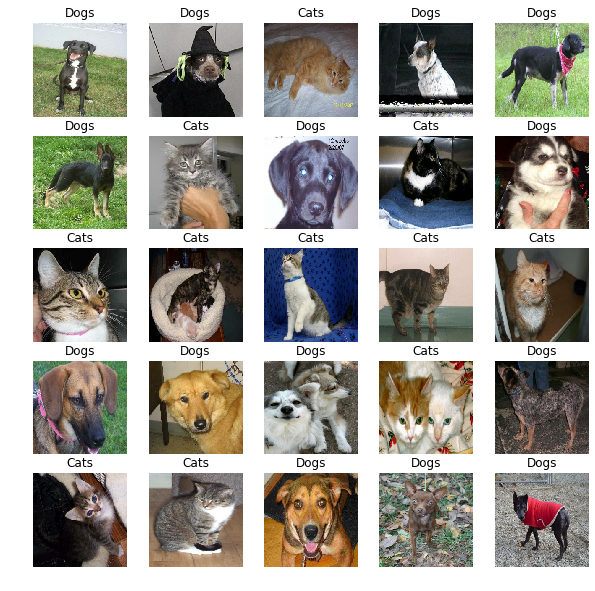

In [93]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
show_batch(image_batch.numpy(), label_batch.numpy())
print(label_batch.numpy())
print(len(label_batch.numpy()))

In [0]:
# define model
model = tf.keras.Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', \
              loss='binary_crossentropy', \
              metrics=['accuracy'])

In [95]:
model.fit_generator(train_ds, steps_per_epoch=STEPS_PER_EPOCH, epochs=2)

Epoch 1/2
63/63 [==============================] - 15s 237ms/step - loss: 0.7103 - accuracy: 0.4953
Epoch 2/2
63/63 [==============================] - 11s 182ms/step - loss: 0.6935 - accuracy: 0.5238


In [99]:
validate_ds = val_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

image_batch, label_batch = next(iter(validate_ds))
images_list = list(image_batch)
print(images_list[0])
print(len(images_list))
for im in next(iter(validate_ds)):
    print(im[0][3].numpy().shape)
# print(labels_list)
# predictions = list(map(model.predict, images_list))
# print(predictions)
pr = []
for item in images_list:
    print(item.shape)
    item = np.expand_dims(item, axis=0)
    print(item.shape)
    pr.append(model.predict(item))
print(pr)


tf.Tensor(
[[0.54901963 0.43921572 0.29411766]
 [0.54704136 0.43723744 0.29213938]
 [0.5485119  0.438708   0.2922444 ]
 [0.56164217 0.45183825 0.30012256]
 [0.5687325  0.4589286  0.30598742]
 [0.5732668  0.46346292 0.31052172]
 [0.57589287 0.46608898 0.31314778]
 [0.48634452 0.3765406  0.2235994 ]
 [0.4069328  0.29712886 0.14343488]
 [0.41743702 0.30763307 0.15131304]
 [0.39460787 0.28480393 0.12794119]
 [0.40012258 0.29110646 0.13188027]
 [0.49203438 0.38564432 0.21853995]
 [0.5585259  0.45264357 0.2840161 ]
 [0.61481094 0.5089286  0.34030116]
 [0.6620798  0.5561975  0.38757005]
 [0.6296744  0.523792   0.35516456]
 [0.6089461  0.50306374 0.3327206 ]
 [0.6483369  0.54245454 0.3668593 ]
 [0.7621324  0.65625006 0.47977945]
 [0.83009464 0.7242122  0.54774165]
 [0.78019965 0.67431724 0.49784666]
 [0.6280288  0.5288166  0.35456938]
 [0.55383414 0.4587886  0.2890232 ]
 [0.65625    0.5585785  0.3966912 ]
 [0.7586661  0.66514367 0.50435936]
 [0.84182435 0.7516283  0.58988106]
 [0.8917192  0.80

InvalidArgumentError: ignored